# Gaussian Process Regression Model 

Squared exponential kernel 

$
k(x_1, x_2) = \sigma^2 \exp{(-||x_2 - x_1||^2_2 / (2 \ell^2))}, 
$
where $\ell > 0$ is the correlation length defines how smooth functions and $\sigma^2 > 0$ defines vertical scale, how srongly functions can span vertically.

Multivariate Normal distribution adoptation

$
\mathcal{N}(K_1 K^{-1} y, K_2 - K_1 K^{-1} K_1^\text{T}) + \sigma^2 I 
$

> for TeX typesetting plese use [Markdown All in One](https://marketplace.visualstudio.com/items?itemName=yzhang.markdown-all-in-one) extension. 

In [1]:
import numpy as np 
from numpy.linalg import inv 

# plotting 
import matplotlib.pyplot as plt 
import seaborn as sns 
import seaborn_image as isns

# interactive 
import ipywidgets as widgets
from ipywidgets import interactive

# use tex fonts
sns.set(font_scale=1.5, rc={'text.usetex' : True})

# this will create thicker lines and larger fonts than usual
isns.set_context("notebook")

# change image related settings
isns.set_image(cmap="deep", despine=True)  # set the colormap and despine the axes
isns.set_scalebar(color="red")             # change scalebar color


/Applications/anaconda3/envs/pyml/lib/python3.7/site-packages/seaborn_image/_context.py:128: UserWarning: Trying to register the cmap 'deep' which already exists.
  register_cmap(name=cmap, cmap=cmap_mpl)


### Code for Square Exponential Kernel (aka RBF) 


In [2]:
class SquareExponentialKernel:

    def __init__(self, sigma=1, ell=1):
        self.sigma = sigma 
        self.ell   = ell 
    
    def __call__(self, x1, x2):
        return self.sigma**2 * np.exp(-np.linalg.norm(x2 - x1)**2 / (2 * self.ell**2))
    

### Understanding of the Gaussian process regression



Sample from univariate Gaussian Distribution 

$
P_X(x) = \dfrac{1}{\sqrt{2 \pi} \sigma} \exp\Big(-\dfrac{(x - \mu)^2}{2 \sigma^2}\Big)
$

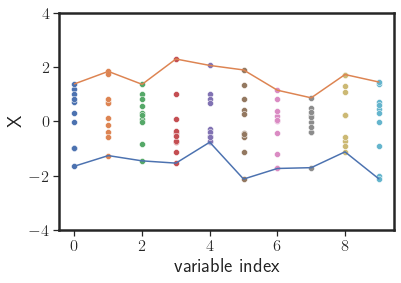

In [3]:
# sample x and y from normal distribution 
nvecs   = 10
samples_num = 10
curves  = []

sns.set_style("white")
sns.set_style("ticks")
for i in range(nvecs):
    # make gaussian vector 
    ys = np.random.normal(size=samples_num)
    xs = [i] * samples_num
    sns.scatterplot(x=xs, y=ys)
    curves.append([np.min(ys), np.max(ys)])

curves = np.array(curves)

for c in range(curves.shape[1]):
    sns.lineplot(x=list(range(nvecs)), y=curves[:, c])

plt.xlabel('variable index')
plt.ylabel('X')
plt.ylim([-4,4])
plt.show()

Sample from the multivariate Gaussian Distribution for $D$-dimensional random vector, components of which are random variables $\vec{X} = (X_0, X_1, ..., X_D)^\text{T}$ reads 

$
N(\vec{\mu}, \Sigma) = \dfrac{1}{\sqrt{(2 \pi)^D |\Sigma| }} \exp\Big(-\dfrac{1}{2} (\vec{X} - \vec{\mu})^\text{T}\Sigma^{-1}(\vec{X} - \vec{\mu})\Big),
$
where $\vec{\mu} = (E[X_0], E[X_1], ..., E[X_D])$, $\Sigma_{i,j} = E[(X_i - \mu_i)(X_j - \mu_j)]$ 

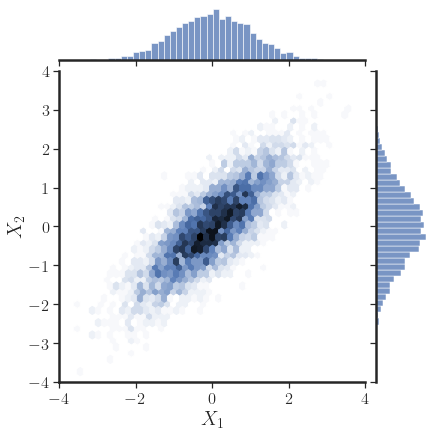

In [4]:
# test mean vector
mean = [0, 0]
# test covariance matrix
cov = [
        [1, 0.8], 
        [0.8, 1]
      ]
# test bivariate sample from multivariate normal distribution
xmg, ymg = np.random.multivariate_normal(mean, cov, 5000).T

sns.jointplot(
    x=xmg, y=ymg,
    kind="hex"
)

plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.xlim([-4, 4])
plt.ylim([-4, 4])
plt.show()

In [5]:
def plot_cov_matr(sigma: float, ell: float):
    """ 
    Plot covariance matrix for given parameters.
    Args:
        sigma : (float) defines vertical scale of the funcion, how much vertically function can span
        ell   : (float) defines horizontal scale, indicates how quickly the correlation relationship 
                between two points drops as their distance increases.
                A higher ell provided a smoother function and a smaller ell a wigglier function.
    """
    # make covariance matrix
    rbf = SquareExponentialKernel(sigma=sigma, ell=ell)
    cov_mv = [[rbf(i, j) for i in np.arange(nvecs)] for j in np.arange(nvecs)]
    vars_lbls = [str(i) for i in range(nvecs)]
    # plot covariance matrix
    fig, ax = plt.subplots(figsize=(6,6)) 
    sns.heatmap(
        cov_mv,
        xticklabels=vars_lbls,
        yticklabels=vars_lbls,
        cmap="YlGnBu",
        annot=True, 
        ax=ax,
        fmt='.1f',
        cbar_kws={'label': 'Correlation'}
        )
    plt.title('Covariance matrix')
    plt.show()

In [6]:
interactive_plot_covmatr = interactive(plot_cov_matr, 
                                       sigma=(0.001, 2.1, 0.1), 
                                       ell=(0.001, 4.0, 0.25),
                                       )
output_covmatr = interactive_plot_covmatr.children[-1]
output_covmatr.layout.height = '400px'
interactive_plot_covmatr

interactive(children=(FloatSlider(value=1.001, description='sigma', max=2.1, min=0.001), FloatSlider(value=1.7…

In [7]:
def plot_prior_curves(sigma: float, ell: float):
    """ 
    Plot curves based on sampled points from multivariate Gaussian distribution.
    Args:
        sigma : (float) defines vertical scale of the funcion, how much vertically function can span
        ell   : (float) defines horizontal scale, indicates how quickly the correlation relationship 
                between two points drops as their distance increases.
                A higher ell provided a smoother function and a smaller ell a wigglier function.
    """
    # make covariance matrix from the RBF kernel 
    rbf = SquareExponentialKernel(sigma=sigma, ell=ell)
    cov_mv = [[rbf(i, j) for i in np.arange(nvecs)] for j in np.arange(nvecs)]
    vars_lbls = [str(i) for i in range(nvecs)]

    mean_mv = nvecs * [0]
    # draw samples from the multivariate gaussian distribution
    ymv = np.random.multivariate_normal(mean_mv, cov_mv, samples_num).T 

    sns.set_style("white")
    sns.set_style("ticks")

    for i in range(3):
        sns.scatterplot(x=range(nvecs), y=ymv[:, i])
        sns.lineplot(x=range(nvecs), y=ymv[:, i])

    plt.xlabel('variable index')
    plt.ylabel('y')
    plt.ylim([-4,4])
    plt.show()

In [8]:
interactive_plot_prior = interactive(plot_prior_curves, 
                                     sigma=(0.001, 2.1, 0.1), 
                                     ell=(0.001, 4.0, 0.25),
                                    )
output_prior = interactive_plot_prior.children[-1]
output_prior.layout.height = '400px'
interactive_plot_prior

interactive(children=(FloatSlider(value=1.001, description='sigma', max=2.1, min=0.001), FloatSlider(value=1.7…

### Conditioning of the Multivariate Gaussian Distribution 

Let us consider the joined distribution of $n$ training outputs $\boldsymbol{X}$ and $m$ test outputs $\boldsymbol{Y}$.


\begin{align}

\begin{bmatrix}
\boldsymbol{X} \\ 
\boldsymbol{Y}
\end{bmatrix} \sim
\mathcal{N}
\Bigg(
0,
\begin{bmatrix}
K(X, X) & K(X, Y) \\ 
K(Y, X) & K(Y, Y) 
\end{bmatrix}
\Bigg)
\end{align}

where $K(X, Y)$ denotes $n \times m$ matrix of the covariances evaluated at all pairs of training and test points, and similarly for the other entries $K(X, X)$, $K(Y, Y)$ and $K(Y, X)$.

 


In [9]:
def get_cond_mean_cov(points_train, points_test, sigma, ell) -> tuple:
    """ 
    Get mean and covariance matrix for conditioned mulitvariate Gaussian distribution.
    Args:
        points_train : (np.array) training points [(x_i, f_i), ...]
        points_test  : (np.array) test points [(x_i, f_i), ...]
        sigma        : (float) defines vertical scale of the funcion, how much vertically function can span
        ell          : (float) defines horizontal scale, indicates how quickly the correlation relationship 
                        between two points drops as their distance increases.
        old_mean     : (np.array) vector of mean for mulitvariate Gaussian distribution
        old_cov      : (np.array) covariance matrix for mulitvariate Gaussian distribution
    Returns:
        (new_mean, new_cov)
    """
    rbf = SquareExponentialKernel(sigma=sigma, ell=ell)

    # abscissas of training and test points
    x_train = points_train[:, 0]
    x_test  = points_test[:, 0]
    
    # ordinates of training points
    y_train = points_train[:, 1].T

    Kxx = np.array([[rbf(_, __) for _ in x_train] for __ in x_train])
    Kxy = np.array([[rbf(_, __) for _ in x_train] for __ in x_test])
    Kyx = np.array([[rbf(_, __) for _ in x_test] for __ in x_train])
    Kyy = np.array([[rbf(_, __) for _ in x_test] for __ in x_test])

    # mean of training and test
    m_train = np.array([0] * x_train.shape[0]).T
    m_test  = np.array([0] * x_test.shape[0]).T
    
    new_mean = Kxy.dot(inv(Kxx)).dot(y_train) 
    new_cov  = Kyy - Kxy.dot(inv(Kxx)).dot(Kyx) 

    return (new_mean, new_cov)

In [22]:
def plot_posterior_curves(sigma: float, ell: float):
    """ 
    Plot curves based on sampled points from multivariate Gaussian distribution.
    Args:
        sigma : (float) defines vertical scale of the funcion, how much vertically function can span
        ell   : (float) defines horizontal scale, indicates how quickly the correlation relationship 
                between two points drops as their distance increases.
                A higher ell provided a smoother function and a smaller ell a wigglier function.
        points: (np.array) ordinate of fixed training points
    """
    # test train points
    points_train = np.array([[0, 0.2], [1, 0.3], [6, 0.5]])
    points_test  = np.array([[2], [3], [4], [5], [7], [8], [9]])

    # compute mean and covariance matrix of the conditioned distribution
    new_mean, new_cov = get_cond_mean_cov(points_train, points_test, sigma, ell)

    # draw samples from the conditioned multivariate gaussian distribution
    ymv = np.random.multivariate_normal(new_mean, new_cov, samples_num).T 
    
    sns.set_style("white")
    sns.set_style("ticks")

    for i in range(5):
        # test points 
        sns.scatterplot(x=points_test[:, 0], y=ymv[:, i])
        # [(x, y), ...] predicted curve 
        temp_pred_xy = np.column_stack((points_test[:, 0], ymv[:, i]))
        temp_curve = np.concatenate((points_train, temp_pred_xy), axis=0)

        sns.lineplot(x=temp_curve[:, 0], y=temp_curve[:, 1])

    # plot train points 
    sns.scatterplot(x=points_train[:, 0], y=points_train[:, 1], color='red', s=200, marker='X')

    plt.xlabel('variable index')
    plt.ylabel('y')
    plt.ylim([-4,4])
    plt.show()

In [23]:
interactive_plot_posterior = interactive(plot_posterior_curves, 
                                       sigma=(0.001, 2.1, 0.1), 
                                       ell=(0.001, 4.0, 0.25),
                                       )
output_posterior = interactive_plot_posterior.children[-1]
output_posterior.layout.height = '400px'
interactive_plot_posterior

interactive(children=(FloatSlider(value=1.001, description='sigma', max=2.1, min=0.001), FloatSlider(value=1.7…

In [60]:
def plot_posterior_curves_continum(sigma: float, ell: float):
    """ 
    Plot curves based on sampled points from multivariate Gaussian distribution.
    Args:
        sigma : (float) defines vertical scale of the funcion, how much vertically function can span
        ell   : (float) defines horizontal scale, indicates how quickly the correlation relationship 
                between two points drops as their distance increases.
                A higher ell provided a smoother function and a smaller ell a wigglier function.
        points: (np.array) ordinate of fixed training points
    """
    curves_num = 100
    # test train points
    points_train = np.array([[0, 1], [1, 2], [2, 0], [3, -2.5]])
    points_test  = np.array([[i] for i in np.arange(0, 4, 0.05) if i not in points_train[:, 0]])

    # compute mean and covariance matrix of the conditioned distribution
    new_mean, new_cov = get_cond_mean_cov(points_train, points_test, sigma, ell)

    # draw samples from the conditioned multivariate gaussian distribution
    ymv   = np.random.multivariate_normal(new_mean, new_cov, curves_num).T 
    ymean = np.mean(ymv, axis=1)
    std   = np.std(ymv, axis=1)
    
    mean_pred_xy = np.column_stack((points_test[:, 0], ymean))
    mean_curve   = np.concatenate((points_train, mean_pred_xy), axis=0)

    std_upper_xy = np.column_stack((points_test[:, 0], ymean + std))
    std_lower_xy = np.column_stack((points_test[:, 0], ymean - std))

    std_upper_curve = np.concatenate((points_train, std_upper_xy), axis=0)
    std_lower_curve = np.concatenate((points_train, std_lower_xy), axis=0)

    sns.set_style("white")
    sns.set_style("ticks")
    # plot mean curve
    sns.lineplot(x=mean_curve[:, 0], y=mean_curve[:, 1], color='red')
    # plot upper uncertainty curve
    sns.lineplot(x=std_upper_curve[:, 0], y=std_upper_curve[:, 1], color='blue') 
    # plot lower uncertainty curve
    sns.lineplot(x=std_lower_curve[:, 0], y=std_lower_curve[:, 1], color='blue') 
    plt.fill_between(std_upper_xy[:, 0], std_upper_xy[:, 1], std_lower_xy[:, 1], alpha=0.2)  

    # plot train points 
    sns.scatterplot(x=points_train[:, 0], y=points_train[:, 1], color='red', s=200, marker='X')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.ylim([-3, 3])
    # plt.savefig('imgs/medium_l.svg')
    plt.show()

In [64]:
interactive_plot_posterior_continum = interactive(plot_posterior_curves_continum, 
                                       sigma=(0.001, 2.1, 0.1), 
                                       ell=(0.001, 2.0, 0.1),
                                       )
output_posterior_continum = interactive_plot_posterior_continum.children[-1]
output_posterior_continum.layout.height = '400px'
interactive_plot_posterior_continum

interactive(children=(FloatSlider(value=1.001, description='sigma', max=2.1, min=0.001), FloatSlider(value=0.9…

### Hyperparameters optimization 

The set of optimal parameters are calculated via optimization of log marginal likelyhood 

$
\log p(\vec{y}| X) = -\dfrac{1}{2} \vec{y}^T (K + \sigma_n^2 I)^{-1} \vec{y} - \dfrac{1}{2} \log |K + \sigma_n^2 I| - \dfrac{n}{2} \log 2 \pi
$

